# CAPSNET Monitor

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
HTML(
'''<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>''')


In [3]:
#%reload_ext watermark
#%watermark
%matplotlib notebook
#%matplotlib inline

import os
os.chdir('/home/jens/eclipse-workspace/MatrixCaps/Matrix-Capsule-Network/')
import torch
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import torch.nn.functional as F
from model import capsules as mcaps
import matplotlib
import numpy as np
import time

import ipywidgets as widgets
from ipywidgets import FloatSlider, HBox, VBox
matplotlib.pyplot.ioff()

import glob
from IPython.display import display, Markdown

## Matrix Capsules LOSS plot

<IPython.core.display.Javascript object>


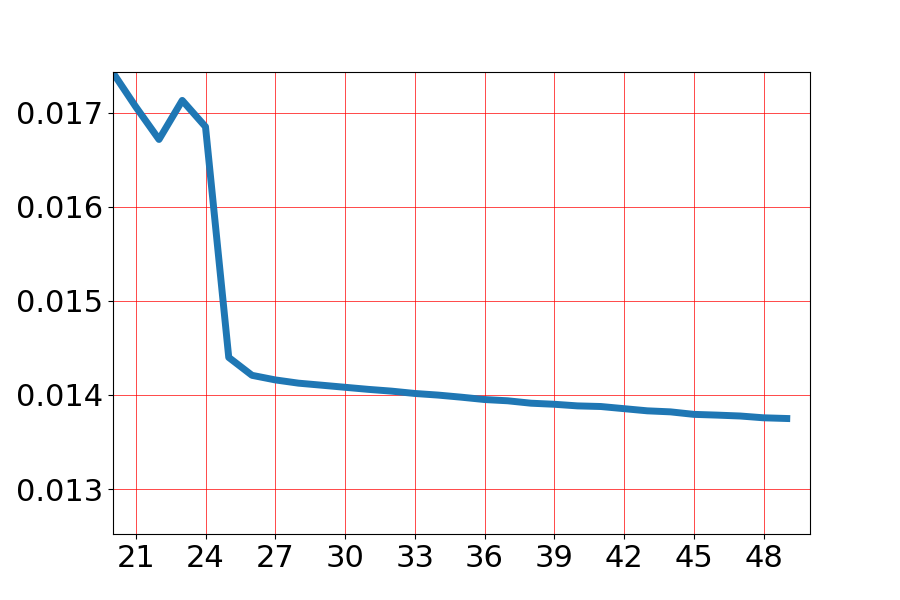

Button(description='Update', style=ButtonStyle())

In [4]:
%matplotlib notebook

matplotlib.rcParams.update({'font.size': 22})
fig3 = matplotlib.pyplot.figure(figsize = (9,6))
#matplotlib.pyplot.gcf().clear()
#fig.clear()
ax3 = fig3.subplots()
matplotlib.pyplot.ion()


button = widgets.Button(description="Update")

def on_button_clicked(b):
    with open('loss.log') as f:
        content = f.readlines()
    content = [float(x.strip()) for x in content]
    xmin = 0
    xmax = len(content)
    if xmax > 30:
        xmin = xmax-30
        content = content[xmin:xmax]
    ymin = np.min(content)
    ymax = np.max(content)
    x_axis = np.linspace(xmin, xmax-1, num=xmax-xmin)

    #matplotlib.pyplot.gcf().clear()
    ax3.clear()
    ax3.set_xlim(xmin, xmax)
    yaxismin = ymin - (ymax-ymin)/3
    if yaxismin < 0:
        yaxismin = 0
    ax3.set_ylim(ymin - (ymax-ymin)/3, ymax)
    ax3.plot(x_axis, content, linewidth=5.0)
    ax3.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax3.grid(linestyle='-', linewidth='0.5', color='red')
    fig3.canvas.draw()

    
on_button_clicked(None)
fig3.show()

display(button)

button.on_click(on_button_clicked)


In [5]:
class args():
    num_classes = 1
    batch_size = 1
    routing = 'EM_routing'
    loss = 'spread_loss̈́'
    use_recon = 0.0005
    r = 3
    num_workers = 1

A, B, C, D, E, r = 64, 8, 16, 16, args.num_classes, args.r  # a small CapsNet

model = mcaps.CapsNet(args, A, B, C, D, E, r)

LatestFile = max(glob.iglob("./weights/em_capsules/*.pth"),key=os.path.getctime)

display(Markdown('## Latest model is: '+LatestFile))

model.load_state_dict(torch.load(LatestFile))
model.cuda()

self = model

## Latest model is: ./weights/em_capsules/model_49.pth

In [6]:
train_dataset = datasets.ImageFolder(root='./data/dumps/', transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True)


## Ground Truth

<IPython.core.display.Javascript object>


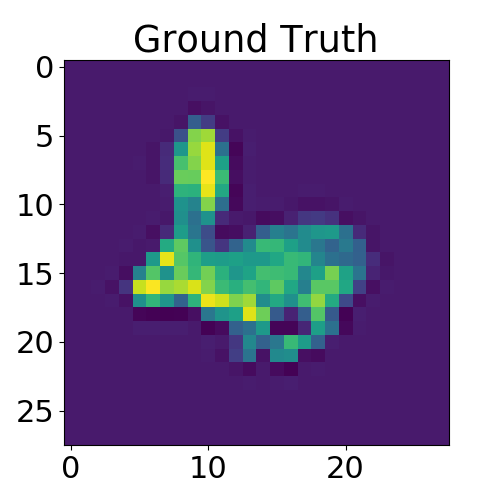

In [11]:
#%matplotlib inline
lambda_ = 1
for data in train_loader:
    imgs, labels = data
    imgs = imgs[:,0,:,:].unsqueeze(1) # use only red channel
    break

fig = matplotlib.pyplot.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.set_title('Ground Truth')
ax.imshow(imgs.squeeze())#, cmap='Greys',  interpolation='nearest')
matplotlib.pyplot.show()
#fig.show()
#fig.canvas.draw()

imgs = Variable(imgs)
imgs = imgs.cuda()

#out_labels, recon = model(imgs, lambda_)#, labels)



In [8]:
def makeCombinedImage(img):
    img = img.squeeze().unsqueeze(1)
    return utils.make_grid(img.data, nrow=int(img.shape[0] ** 0.5), normalize=True,range=(0, 1)).cpu().numpy()
    
def forward(self, x, lambda_, p=None):

    if p is None:
        x = F.relu(self.conv1(x))  # b,32,12,12

        fig = matplotlib.pyplot.figure(figsize = (8,8))
        ax1 = fig.add_subplot(1,1,1)
        grid_picture = makeCombinedImage(x[0])
        ax1.imshow(grid_picture.transpose(1,2,0))
        ax1.set_title('layer 1')

        x = self.primary_caps(x)  # b,32*(4*4+1),12,12

        fig2 = matplotlib.pyplot.figure(figsize = (8,8))
        ax2 = fig2.add_subplot(1,1,1)
        grid_picture = makeCombinedImage(x[0])
        ax2.imshow(grid_picture.transpose(1,2,0))
        ax2.set_title('layer 2')

        matplotlib.pyplot.show()
            
        x = self.convcaps1(x, lambda_)  # b,32*(4*4+1),5,5
        x = self.convcaps2(x, lambda_)  # b,32*(4*4+1),3,3
        p, a = self.classcaps(x, lambda_)  # b,10*16+10

        p = p.squeeze()

        # When batch size = 1
        if len(p.shape) == 1:
            p = p.unsqueeze(0)
            
    reconstructions = self.decoder(p)

    return reconstructions, p

## Receptive fields of convolutional layer and primary capsules layer

<IPython.core.display.Javascript object>


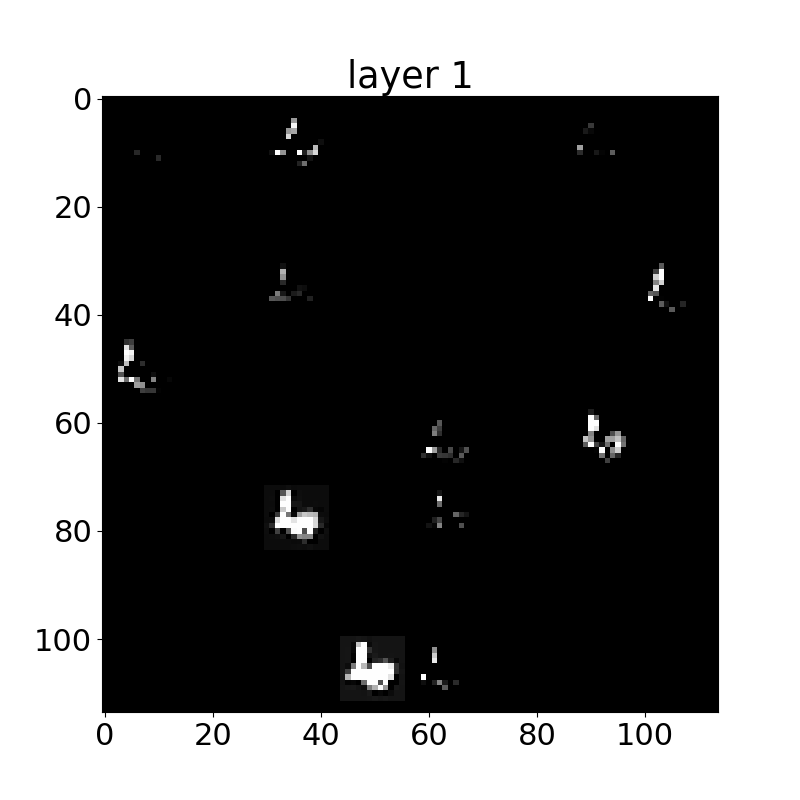

<IPython.core.display.Javascript object>


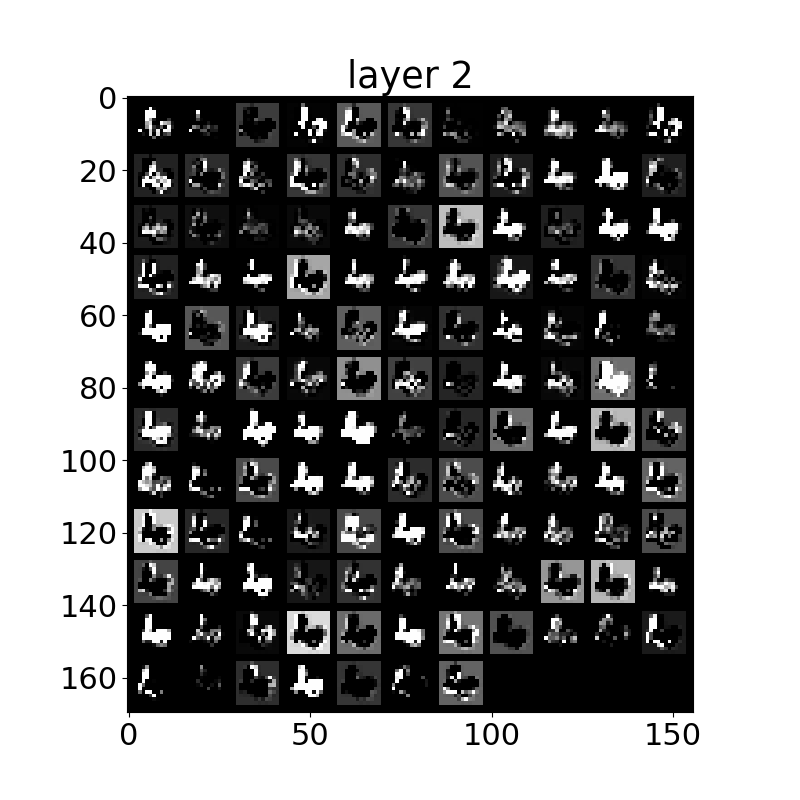

In [12]:
reconstruction, pose = forward(self, imgs, lambda_)

## 4x4 pose output

<IPython.core.display.Javascript object>


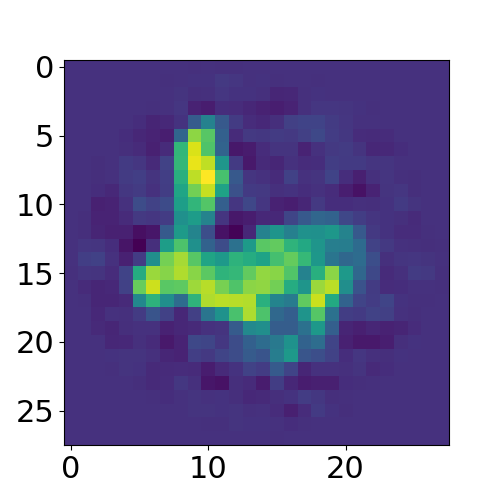

In [13]:
#for i in range(10):
#    %matplotlib notebook

maxval = pose.max(1)[0].item()
minval = pose.min(1)[0].item()

names = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15']
pose_sliders = [FloatSlider(min=minval, max=maxval, step=0.00001, description=i, orientation='vertical') for i in names]

reconstruction, pose = forward(self, None, None, p=pose)

recon = reconstruction.data.view(int(reconstruction.shape[1] ** 0.5), -1).cpu().numpy()

fig = matplotlib.pyplot.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.set_title('Reconstruction')
ax.imshow(recon)
matplotlib.pyplot.ion()
fig.show()
fig.canvas.draw()



def on_value_change(change):
    for i in range(len(pose_sliders)):
        pose[:,i] = pose_sliders[i].value
    reconstruction, p = forward(self, None, None, p=pose)
    recon = reconstruction.data.view(int(reconstruction.shape[1] ** 0.5), -1).cpu().numpy()
    ax.clear()
    ax.imshow(recon)
    fig.canvas.draw()

for i in range(len(pose_sliders)):
    kaj = pose[:,i].item()
    pose_sliders[i].value = kaj

for i in range(len(pose_sliders)):
    pose_sliders[i].observe(on_value_change)
    
vbox = VBox( [HBox(pose_sliders[:8]), HBox(pose_sliders[8:16])] )
display(vbox)